## Posteriors on $\left(\zeta, T_{\rm vir}^{\rm min}, R_{\rm mfp}, \log_{10}(L_{\rm X}), E_0, \alpha_{\rm X}\right)$ from the 21-cm power spectra.

---
Copy the store to the local gpu computing node

In [1]:
%%time
!cp -r /scratch/p303146/21cmPk_SeedVar* /tmp/

CPU times: user 8.03 s, sys: 745 ms, total: 8.77 s
Wall time: 6min 6s


---
Importing dependencies

In [11]:
import sys; sys.path.insert(1, "./../../../")
from swyft21cm.utils.interpolation import calc_kSpline, interp_pk, interp_plan
from swyft21cm.utils.plot import corner

import os
import seaborn as sns
import numpy as np
np.random.seed(27);

from scipy import stats
import torch
torch.manual_seed(27);

import swyft as sl
import pytorch_lightning as pl
import pickle

from tabulate import tabulate
import matplotlib.pyplot as plt
plt.rcParams["mathtext.fontset"] = "stix"
%matplotlib inline

---
Redshifts, Prior, Paths

In [12]:
# Redshifts
reds = [24.359810, 20.219959, 17.111031, 14.457590, 12.456770,
        10.714930, 9.402521, 8.237142, 7.202319, 6.429094]

# Parameters: zeta, Tvir, Rmfp, Lx, E0, alpha
labels = [r'$\zeta$', r'$\log_{10}(T_{\rm vir}^{\rm min})$', r'$R_{\rm mfp}$',
          r'$\log_{10}(L_{\rm X})$', r'$E_0$', r'$\alpha_{\rm X}$']

# True values of the parameters
vtrue = np.array([30, 4.69897, 15, 40.5, 500, 1])

# Priors
vmin = np.array([10, 4.2, 8, 39.5, 100, -0.5])
vmax = np.array([100, 5.2, 22, 41.5, 900, 2.5])

# k-modes from sim box (no cut applied)
kModes = np.load("./../../data/kModes.npy")

# Parameters for interpolation
Nspline_points = 8
Foreground_cut = 0.1
Shot_Noise_cut = 0.8

# Path for mock observation and noise
noisePath = "./../../data/ska_low_noise.npy"
obsPath = "./../../data/mockObs.pkl"

# accelerator for the trainer
accelerator = "cuda" if torch.cuda.is_available() else "cpu"

In [13]:
kSpline = calc_kSpline(Foreground_cut, Shot_Noise_cut, Nspline_points)
print('k-modes:', kSpline)

k-modes: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


---
SKA noise simulated using `ps_eor`

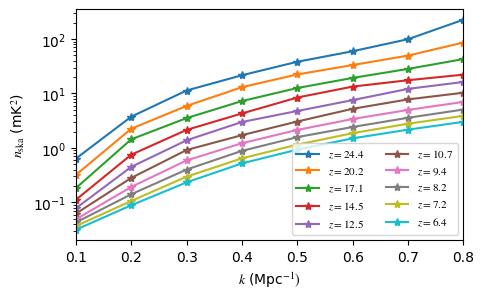

In [14]:
# Instrumental noise level from SKA low: sim using ps_eor
instNoise = np.load(noisePath)

fig, ax = plt.subplots(figsize=(5, 3))
for i in range(len(reds)):
    ax.plot(kSpline, instNoise[i], "*-", label=r"$z = %.1f$"%reds[i])
    ax.set_yscale("log")
    ax.set_xlim(kSpline[0], kSpline[-1])
    ax.legend(ncol=2, fontsize=8)
    ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    ax.set_ylabel(r"$n_{\rm ska}$ (mK$^2$)")

---
Mock observation

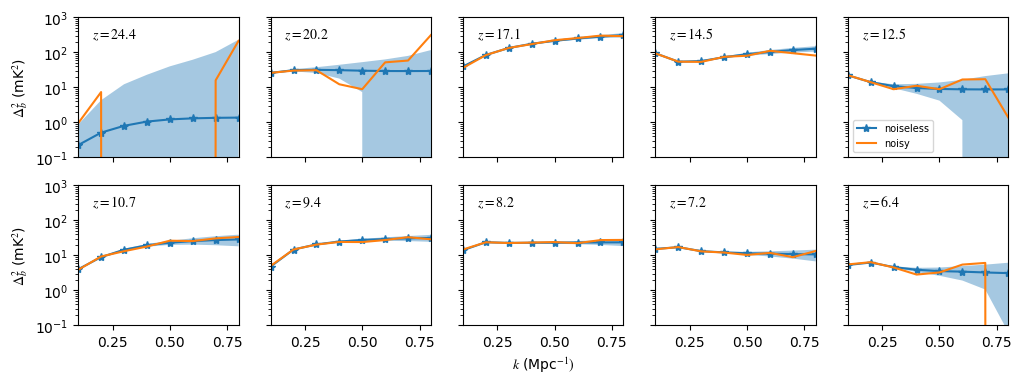

In [15]:
with open(obsPath, 'rb') as f:
    obs0 = pickle.load(f)
    
fig, ax = plt.subplots(2, 5, figsize=(12, 4), sharex=True, sharey=True)
for i, ax in enumerate(fig.axes):
    sigma = np.sqrt(instNoise[i]**2. + (obs0['pk_sv_z%.1f'%reds[i]].numpy())**2.)
    ax.plot(kSpline, obs0['pk_mu_z%.1f'%reds[i]], "*-", label="noiseless")
    ax.fill_between(kSpline, obs0['pk_mu_z%.1f'%reds[i]] - sigma,
                   obs0['pk_mu_z%.1f'%reds[i]] + sigma, alpha=0.4)
    ax.plot(kSpline, obs0['pk_z%.1f'%reds[i]], label="noisy")
    ax.set_ylim(1e-1, 1e3)
    ax.set_xlim(kSpline[0], kSpline[-1])
    ax.set_yscale("log")
    if i == 4: ax.legend(loc="lower left", fontsize=7)
    if i == 7: ax.set_xlabel(r"$k$ (Mpc$^{-1})$")
    if i == 0 or i == 5: ax.set_ylabel(r"$\Delta_{b}^2$ (mK$^2$)")
    ax.text(0.16, 2.5*1e2, r"$z=%.1f$"%reds[i], fontsize=10)

---
Noise model to be used on-the-fly

In [16]:
# Use it as a hook: takes into account the instrumental noise
def noise(out):
    for i in range(len(reds)):
        mu = out['pk_mu_z%.1f'%reds[i]]
        
        # Interpolate the model power spectra (pk_mod)
        splined_mod = interp_plan(k=kModes, pk=mu)
        mu_val = interp_pk(pk_spl=splined_mod, kSpline=kSpline, Nspline_points=Nspline_points)

        # Check for nan values.
        if np.isnan(np.sum(mu_val)):
            mu_val = np.zeros(len(kSpline))

        n = np.float32(np.random.randn(*instNoise[i].shape))*instNoise[i]
        out['pk_z%.1f'%reds[i]] = mu_val + n
    return out

---
Data loaders: Train, Val, Test

In [17]:
zs = sl.ZarrStore("/tmp/21cmPk_SeedVar/")
data_loader_train = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[0, 16_000],
                                      on_after_load_sample=noise)
data_loader_val = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[16_000, 18_000],
                                    on_after_load_sample=noise)
data_loader_test = zs.get_dataloader(num_workers=0, batch_size=64, idx_range=[18_000, 20_000],
                                     on_after_load_sample=noise)

---
Quick test to check if interpolation works fine

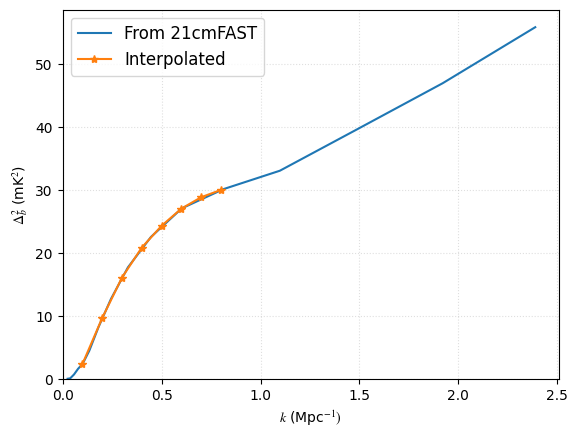

In [18]:
pk_mod = zs.data['pk_mu_z10.7'][0]
samp_var_mod = zs.data['pk_sv_z10.7'][0]

# Interpolate the model power spectra (pk_mod)
splined_mod = interp_plan(k=kModes, pk=pk_mod)
pk_mod_val = interp_pk(pk_spl=splined_mod, kSpline=kSpline, Nspline_points=Nspline_points)

# Check for nan values.
if np.isnan(np.sum(pk_mod_val)):
    pk_mod_val = np.zeros(len(kSpline))

plt.plot(kModes, pk_mod, label="From 21cmFAST");
plt.plot(kSpline, pk_mod_val, "-*", label="Interpolated");
plt.legend(fontsize=12)
plt.xlim(0,)
plt.ylim(0,)
plt.xlabel(r"$k$ (Mpc$^{-1})$")
plt.ylabel(r"$\Delta_{b}^2$ (mK$^2$)")
plt.grid(ls=":", alpha=0.4)

---
Trainer, callbacks, logger

In [19]:
logger = pl.loggers.TensorBoardLogger("./lightning_logs", name = "post_1D_2D")
model_checkpoint = pl.callbacks.ModelCheckpoint(monitor = 'val_loss', save_top_k=1)
callbacks = [
    pl.callbacks.LearningRateMonitor(),
    pl.callbacks.EarlyStopping("val_loss", patience=8),
    model_checkpoint
]

In [20]:
trainer = sl.SwyftTrainer(accelerator=accelerator, max_epochs=100, logger=logger,
                          callbacks=callbacks, precision=64)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


---
Network architecture

In [21]:
class Network(sl.SwyftModule):
    def __init__(self, lr=1e-3, gamma=1.):
        super().__init__()
        self.n_features = 64
        self.optimizer_init = sl.OptimizerInit(torch.optim.Adam, dict(lr = lr),
                                                  torch.optim.lr_scheduler.ExponentialLR,
                                                  dict(gamma = gamma, verbose=False))
        marginals = self.get_marginals(n_params=len(vtrue))
        self.l = torch.nn.Linear(80, self.n_features)
        
        # Train 1D ratios
        self.logratios1 = sl.LogRatioEstimator_1dim(num_features=self.n_features,
                                                    num_params=len(vtrue),
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames='z')
        
        # Train 2D ratios
        self.logratios2 = sl.LogRatioEstimator_Ndim(num_features=self.n_features,
                                                    marginals=marginals,
                                                    hidden_features=256,
                                                    num_blocks=3,
                                                    dropout=0.2,
                                                    varnames ='z')

    @staticmethod
    def get_marginals(n_params):
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
        
    def forward(self, A, B):
        x = torch.cat([A['pk_z%.1f'%zi] for zi in reds], axis=1)
        x = self.l(x)
        z = B['z']
        ratios_1 = self.logratios1(x, z)
        ratios_2 = self.logratios2(x, z)
        return ratios_1, ratios_2

In [22]:
network = Network(lr=1e-3, gamma=0.95)

---
Training the network

In [23]:
%%time
if os.path.exists("./output/01_trainedLogRatios_20k.pt"):
    network.load_state_dict(torch.load("./output/01_trainedLogRatios_20k.pt"))
else:
    trainer.fit(network, data_loader_train, data_loader_val)

CPU times: user 16.3 ms, sys: 37.7 ms, total: 54.1 ms
Wall time: 70.4 ms


---
Save the trained model

In [24]:
if not os.path.exists("./output/01_trainedLogRatios_20k.pt"):
    torch.save(network.state_dict(), "./output/01_trainedLogRatios_20k.pt")

---
Network's performance on the test dataset

In [25]:
trainer.test(network, data_loader_test)

You are using a CUDA device ('NVIDIA A100-PCIE-40GB MIG 4g.20gb') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2023-08-08 03:27:41.926384: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-08 03:27:47.837751: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild Tensor

Testing: 0it [00:00, ?it/s]

/home3/p303146/Projects/swyft21cm/analysis/inference/./../../../swyft21cm/utils/interpolation.py:15: RuntimeWarning: divide by zero encountered in log10
  return scipy.interpolate.splrep(k, np.log10(pk), s=0)


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    -22.244184625838496    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': -22.244184625838496}]

---
Sampling from the prior

In [26]:
def uv(u):
    return u * (vmax - vmin) + vmin

prior_samples = sl.Samples(z = uv(np.random.rand(200_000, 6)).astype('f'))

---
Predictions for the mock observation (`FAINT GALAXIES` model)

In [27]:
%%time
if not os.path.exists("./output/01_logRatioSamples_20k.pkl"):
    pred = trainer.infer(network, sl.Sample(obs0), prior_samples)
else:
    file = open("./output/01_logRatioSamples_20k.pkl", "rb")
    pred = pickle.load(file)
    file.close()

CPU times: user 20.9 ms, sys: 36.8 ms, total: 57.7 ms
Wall time: 62.7 ms


---
Save the logratio samples 

In [28]:
if not os.path.exists("./output/01_logRatioSamples_20k.pkl"):
    open_file = open("./output/01_logRatioSamples_20k.pkl", "wb")
    pickle.dump(pred, open_file)
    open_file.close()

---
To convert the unit of $E_0$ from eV to keV

In [29]:
index_y = [3, 7, 10, 12]
for i in index_y:
    pred[1].params[:, i, 1] = pred[1].params[:, i, 1]/1000.
    
pred[0].params[:, 4, 0] = pred[0].params[:, 4, 0]/1000.
pred[1].params[:, 14, 0] = pred[1].params[:, 14, 0]/1000.

---
Corner plot! ☺

┍━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┯━━━━━━━━━━━┑
│      mean │       -1s │       +1s │       -2s │       +2s │       -3s │       +3s │
┝━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┿━━━━━━━━━━━┥
│ 30.25     │ 1.79999   │ 2.69999   │ 5.39998   │ 5.39998   │ 8.09997   │ 8.99997   │
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│  4.695    │ 0.0200005 │ 0.0299997 │ 0.0500002 │ 0.0599995 │ 0.0899992 │ 0.0899992 │
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ 14.6501   │ 0.559988  │ 0.559989  │ 1.25997   │ 1.25997   │ 1.95996   │ 1.95996   │
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│ 40.49     │ 0.0600014 │ 0.0399971 │ 0.119999  │ 0.119999  │ 0.200001  │ 0.179996  │
├───────────┼───────────┼───────────┼───────────┼───────────┼───────────┼───────────┤
│  0.504    │ 0.0319999 │ 0.0319997 │ 0.0719996 │ 0.07

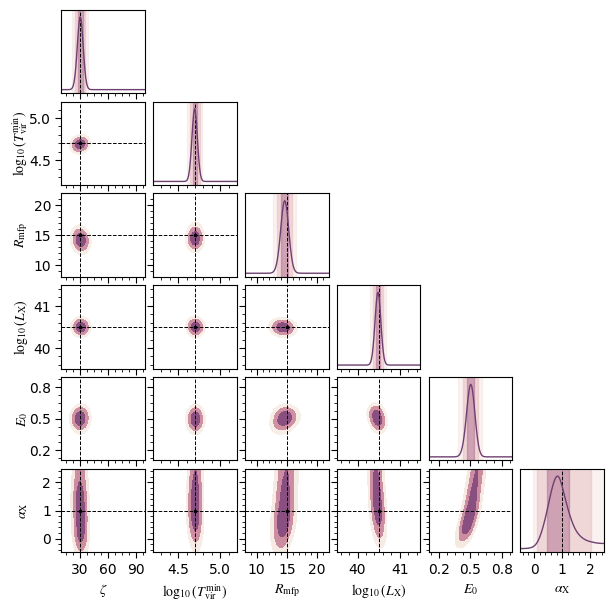

In [30]:
cmap = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=True)
cmap_2 = sns.cubehelix_palette(start=0, light=0.98, dark=0.4, as_cmap=False)
col = sns.cubehelix_palette(5)[3]

corner(pred, parnames=("z[0]", "z[1]", "z[2]", "z[3]", "z[4]", "z[5]"), smooth=3,
       labels=labels, color=col, cmap=cmap, cmap_2=cmap_2, vtrue=vtrue);